# Santa Fe Bar Problem: Discrete vs Continuous MFG Formulations

## Mathematical Comparison

The Santa Fe Bar Problem can be formulated in two mathematically distinct ways:

### 1. **Discrete State MFG** (Mathematically Correct)

**State Space**: Discrete {0: Stay Home, 1: Go to Bar}

**System**: Coupled ODEs (no spatial derivatives)

**HJB Equations**:
$$-\frac{du_1}{dt} = F(m(t)) - \nu \log(1 + e^{(u_0 - u_1)/\nu})$$
$$-\frac{du_0}{dt} = U_{\text{home}} - \nu \log(1 + e^{(u_1 - u_0)/\nu})$$

**FPK Equation**:
$$\frac{dm}{dt} = (1-m(t)) \cdot P_{0 \to 1} - m(t) \cdot P_{1 \to 0}$$

**Transition Probabilities** (Logit Model):
$$P_{0 \to 1} = \frac{e^{u_1/\nu}}{e^{u_0/\nu} + e^{u_1/\nu}}, \quad P_{1 \to 0} = \frac{e^{u_0/\nu}}{e^{u_0/\nu} + e^{u_1/\nu}}$$

### 2. **Continuous State MFG** (Approximation)

**State Space**: Continuous $x \in [0,1]$ (tendency to attend)

**System**: Coupled PDEs with spatial derivatives

**HJB Equation**:
$$-\frac{\partial U}{\partial t} = \min_u \left[ L(t,x,u,m) + u \frac{\partial U}{\partial x} + \frac{\sigma^2}{2} \frac{\partial^2 U}{\partial x^2} \right]$$

**FPK Equation**:
$$\frac{\partial m}{\partial t} = -\frac{\partial}{\partial x}[u(t,x)m(t,x)] + \frac{\sigma^2}{2}\frac{\partial^2 m}{\partial x^2}$$

**Cost Function**:
$$L(t,x,u,m) = \alpha \max(0, A(t) - \bar{C})^2 + \frac{1}{2}u^2 + \beta(x - x_{\text{hist}})^2$$

## Implementation and Comparison

In [1]:
import os

# Import our implementations
import sys

import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "advanced"))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "basic"))

from santa_fe_bar_discrete_mfg import DiscreteSantaFeBarMFG

from mfg_pde import ExampleMFGProblem, create_fast_solver
from mfg_pde.utils.logging import configure_research_logging, get_logger

configure_research_logging("santa_fe_comparison", level="INFO")
logger = get_logger(__name__)

print("🍺 Santa Fe Bar Problem: Discrete vs Continuous MFG Comparison")
print("=" * 70)

2025-07-28 07:58:42 - mfg_pde.research     - INFO     - Research session started: santa_fe_comparison
2025-07-28 07:58:42 - mfg_pde.research     - INFO     - Log file: research_logs/santa_fe_comparison_20250728_075842.log
2025-07-28 07:58:42 - mfg_pde.research     - INFO     - Logging level: INFO
🍺 Santa Fe Bar Problem: Discrete vs Continuous MFG Comparison


/Users/zvezda/Library/CloudStorage/OneDrive-Personal/code/MFG_PDE/mfg_pde/alg/hjb_solvers/hjb_gfdm_optimized.py:20: UserWarning:

CVXPY not available. Install with 'pip install cvxpy' for optimal performance.



### Discrete MFG Solution

In [2]:
# Solve discrete MFG with balanced parameters
print("📊 Solving Discrete State MFG...")

discrete_problem = DiscreteSantaFeBarMFG(
    T=10.0,
    m_threshold=0.6,
    payoff_good=5.0,  # Reduced from 10.0 for more balanced behavior
    payoff_bad=-2.0,  # Reduced magnitude from -5.0
    payoff_home=0.0,
    noise_level=2.0,  # Increased noise for smoother transitions
    initial_m=0.5,
)

discrete_solution = discrete_problem.solve(nt=1000)
discrete_analysis = discrete_problem.analyze_equilibrium(discrete_solution)

print("✅ Discrete MFG Results:")
print(f"  • Final attendance: {discrete_analysis['steady_state_attendance']:.1%}")
print(f"  • Economic efficiency: {discrete_analysis['efficiency']:.1%}")
print(f"  • Regime: {discrete_analysis['regime']}")
print(f"  • Value difference: {discrete_analysis['value_difference']:.3f}")

📊 Solving Discrete State MFG...
2025-07-28 07:58:42 - santa_fe_bar_discrete_mfg - INFO     - Initialized Discrete Santa Fe Bar MFG: threshold=0.6, noise=2.0, T=10.0
2025-07-28 07:58:42 - santa_fe_bar_discrete_mfg - INFO     - 🚀 Solving Discrete Santa Fe Bar MFG...
2025-07-28 07:58:42 - santa_fe_bar_discrete_mfg - INFO     - ✅ Solution completed in 0.075 seconds
2025-07-28 07:58:42 - santa_fe_bar_discrete_mfg - INFO     - Final attendance: 7.6%, Final values: u0=2.308, u1=-2.692
✅ Discrete MFG Results:
  • Final attendance: 7.6%
  • Economic efficiency: 12.7%
  • Regime: underutilized
  • Value difference: -5.000


### Continuous MFG Solution (for comparison)

In [3]:
# Solve continuous MFG approximation
print("\n📊 Solving Continuous State MFG (Approximation)...")


def analyze_continuous_solution(problem, U, M):
    """Analyze continuous MFG solution."""
    x_grid = np.linspace(problem.xmin, problem.xmax, M.shape[1])

    attendance_rates = []
    for t_idx in range(M.shape[0]):
        attendance = np.trapezoid(x_grid * M[t_idx, :], x_grid)
        attendance_rates.append(attendance)

    final_attendance = attendance_rates[-1]
    efficiency = 1.0 - abs(final_attendance - 0.6) / 0.6

    return {"attendance_evolution": attendance_rates, "final_attendance": final_attendance, "efficiency": efficiency}


continuous_problem = ExampleMFGProblem(xmin=0.0, xmax=1.0, Nx=40, T=10.0, Nt=40, sigma=0.15, coefCT=0.2)
continuous_problem.bar_capacity = 0.6

solver = create_fast_solver(continuous_problem, solver_type="fixed_point")
result = solver.solve()
U, M = result.U, result.M

continuous_analysis = analyze_continuous_solution(continuous_problem, U, M)

print("✅ Continuous MFG Results:")
print(f"  • Final attendance: {continuous_analysis['final_attendance']:.1%}")
print(f"  • Economic efficiency: {continuous_analysis['efficiency']:.1%}")
print(f"  • Converged: {result.convergence_achieved}")


📊 Solving Continuous State MFG (Approximation)...

🚀 HJB-FDM_FP-FDM (Config-Aware)
📋 Configuration:
   • Picard iterations: 10
   • Picard tolerance: 1.00e-03
   • Damping factor: 0.7
   • Return format: Structured
   • Warm start: Disabled
❄️ Cold start initialization

📊 Picard Iteration 1/10
   ⏱️  Time: 0.107s
   📉 Errors: U=1.00e+00, M=9.91e-01

📊 Picard Iteration 2/10
   ⏱️  Time: 0.107s
   📉 Errors: U=2.99e-01, M=1.12e+00

📊 Picard Iteration 3/10
   ⏱️  Time: 0.221s
   📉 Errors: U=3.43e-01, M=1.12e+00

📊 Picard Iteration 4/10
   ⏱️  Time: 0.102s
   📉 Errors: U=2.06e-01, M=1.09e+00

📊 Picard Iteration 5/10
   ⏱️  Time: 0.104s
   📉 Errors: U=1.25e+00, M=1.17e+00

📊 Picard Iteration 6/10
   ⏱️  Time: 0.136s
   📉 Errors: U=6.83e-01, M=6.36e-01

📊 Picard Iteration 7/10
   ⏱️  Time: 0.103s
   📉 Errors: U=9.26e-01, M=1.08e+00

📊 Picard Iteration 8/10
   ⏱️  Time: 0.100s
   📉 Errors: U=6.50e-01, M=1.18e+00

📊 Picard Iteration 9/10
   ⏱️  Time: 0.106s
   📉 Errors: U=9.38e-01, M=9.73e-01


### Side-by-Side Comparison

/var/folders/h0/y8mmglb15dg5sq0bjhtqjvn80000gn/T/ipykernel_17182/2501745793.py:138: UserWarning:

Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.

/var/folders/h0/y8mmglb15dg5sq0bjhtqjvn80000gn/T/ipykernel_17182/2501745793.py:138: UserWarning:

Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.

/opt/homebrew/anaconda3/envs/mfg_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.

/opt/homebrew/anaconda3/envs/mfg_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.



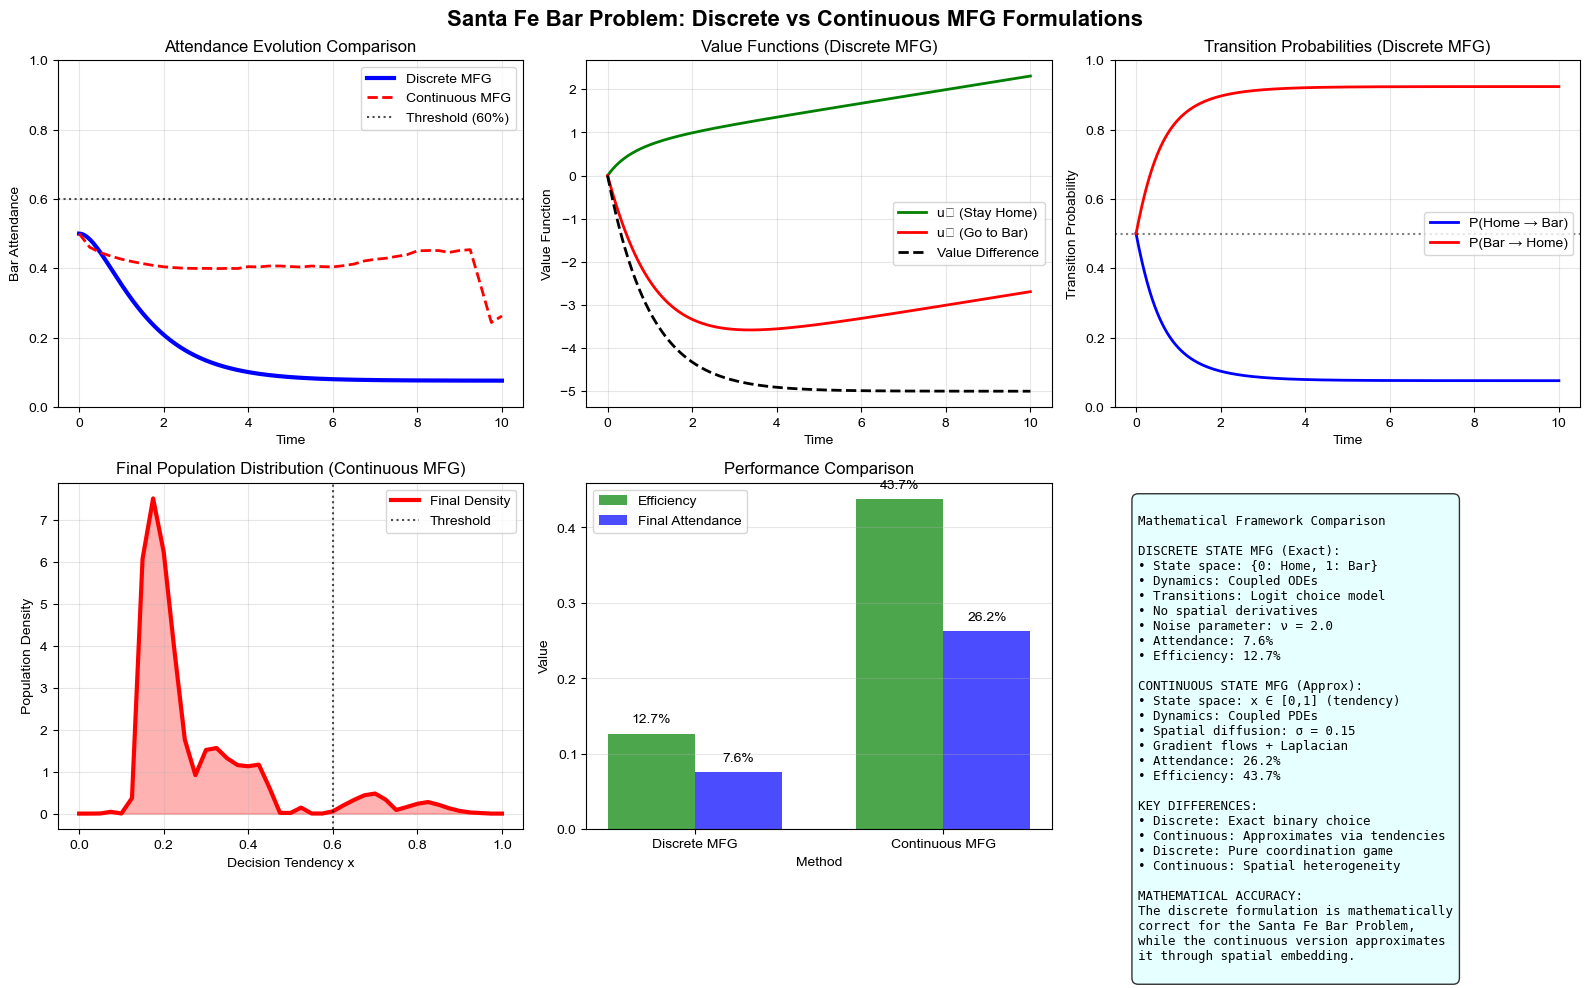


📊 Comparison Summary:
Discrete MFG  - Final Attendance: 7.6%, Efficiency: 12.7%
Continuous MFG - Final Attendance: 26.2%, Efficiency: 43.7%


In [4]:
# Create comprehensive comparison visualization
fig = plt.figure(figsize=(16, 10))
fig.suptitle("Santa Fe Bar Problem: Discrete vs Continuous MFG Formulations", fontsize=16, fontweight="bold")

# Discrete MFG Results
t_discrete = discrete_solution["time"]
m_discrete = discrete_solution["attendance"]
u0_discrete = discrete_solution["u0"]
u1_discrete = discrete_solution["u1"]

# Continuous MFG Results
t_continuous = np.linspace(0, continuous_problem.T, M.shape[0])
m_continuous = continuous_analysis["attendance_evolution"]

# 1. Attendance Comparison
ax1 = plt.subplot(2, 3, 1)
ax1.plot(t_discrete, m_discrete, "b-", linewidth=3, label="Discrete MFG")
ax1.plot(t_continuous, m_continuous, "r--", linewidth=2, label="Continuous MFG")
ax1.axhline(y=0.6, color="black", linestyle=":", alpha=0.7, label="Threshold (60%)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Bar Attendance")
ax1.set_title("Attendance Evolution Comparison")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# 2. Value Functions (Discrete only)
ax2 = plt.subplot(2, 3, 2)
ax2.plot(t_discrete, u0_discrete, "g-", linewidth=2, label="u₀ (Stay Home)")
ax2.plot(t_discrete, u1_discrete, "r-", linewidth=2, label="u₁ (Go to Bar)")
ax2.plot(t_discrete, u1_discrete - u0_discrete, "k--", linewidth=2, label="Value Difference")
ax2.set_xlabel("Time")
ax2.set_ylabel("Value Function")
ax2.set_title("Value Functions (Discrete MFG)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Transition Probabilities (Discrete only)
ax3 = plt.subplot(2, 3, 3)
P_0_to_1 = discrete_solution["P_0_to_1"]
P_1_to_0 = discrete_solution["P_1_to_0"]
ax3.plot(t_discrete, P_0_to_1, "b-", linewidth=2, label="P(Home → Bar)")
ax3.plot(t_discrete, P_1_to_0, "r-", linewidth=2, label="P(Bar → Home)")
ax3.axhline(y=0.5, color="black", linestyle=":", alpha=0.5)
ax3.set_xlabel("Time")
ax3.set_ylabel("Transition Probability")
ax3.set_title("Transition Probabilities (Discrete MFG)")
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)

# 4. Population Density (Continuous only)
ax4 = plt.subplot(2, 3, 4)
x_grid = np.linspace(continuous_problem.xmin, continuous_problem.xmax, M.shape[1])
final_density = M[-1, :]
ax4.plot(x_grid, final_density, "r-", linewidth=3, label="Final Density")
ax4.fill_between(x_grid, final_density, alpha=0.3, color="red")
ax4.axvline(x=0.6, color="black", linestyle=":", alpha=0.7, label="Threshold")
ax4.set_xlabel("Decision Tendency x")
ax4.set_ylabel("Population Density")
ax4.set_title("Final Population Distribution (Continuous MFG)")
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Efficiency Comparison
ax5 = plt.subplot(2, 3, 5)
methods = ["Discrete MFG", "Continuous MFG"]
efficiencies = [discrete_analysis["efficiency"], continuous_analysis["efficiency"]]
attendances = [discrete_analysis["steady_state_attendance"], continuous_analysis["final_attendance"]]

x_pos = np.arange(len(methods))
width = 0.35

bars1 = ax5.bar(x_pos - width / 2, efficiencies, width, label="Efficiency", alpha=0.7, color="green")
bars2 = ax5.bar(x_pos + width / 2, attendances, width, label="Final Attendance", alpha=0.7, color="blue")

ax5.set_xlabel("Method")
ax5.set_ylabel("Value")
ax5.set_title("Performance Comparison")
ax5.set_xticks(x_pos)
ax5.set_xticklabels(methods)
ax5.legend()
ax5.grid(True, alpha=0.3, axis="y")

# Add value labels on bars
for bar, value in zip(bars1, efficiencies, strict=False):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width() / 2.0, height + 0.01, f"{value:.1%}", ha="center", va="bottom", fontsize=10)

for bar, value in zip(bars2, attendances, strict=False):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width() / 2.0, height + 0.01, f"{value:.1%}", ha="center", va="bottom", fontsize=10)

# 6. Mathematical Comparison Summary
ax6 = plt.subplot(2, 3, 6)
ax6.axis("off")

comparison_text = f"""
Mathematical Framework Comparison

DISCRETE STATE MFG (Exact):
• State space: {{0: Home, 1: Bar}}
• Dynamics: Coupled ODEs
• Transitions: Logit choice model
• No spatial derivatives
• Noise parameter: ν = {discrete_problem.noise_level}
• Attendance: {discrete_analysis["steady_state_attendance"]:.1%}
• Efficiency: {discrete_analysis["efficiency"]:.1%}

CONTINUOUS STATE MFG (Approx):
• State space: x ∈ [0,1] (tendency)
• Dynamics: Coupled PDEs
• Spatial diffusion: σ = {continuous_problem.sigma}
• Gradient flows + Laplacian
• Attendance: {continuous_analysis["final_attendance"]:.1%}
• Efficiency: {continuous_analysis["efficiency"]:.1%}

KEY DIFFERENCES:
• Discrete: Exact binary choice
• Continuous: Approximates via tendencies
• Discrete: Pure coordination game
• Continuous: Spatial heterogeneity

MATHEMATICAL ACCURACY:
The discrete formulation is mathematically
correct for the Santa Fe Bar Problem,
while the continuous version approximates
it through spatial embedding.
    """

ax6.text(
    0.05,
    0.95,
    comparison_text,
    transform=ax6.transAxes,
    fontsize=9,
    verticalalignment="top",
    fontfamily="monospace",
    bbox={"boxstyle": "round,pad=0.5", "facecolor": "lightcyan", "alpha": 0.8},
)

plt.tight_layout()
plt.show()

print("\n📊 Comparison Summary:")
print(
    f"Discrete MFG  - Final Attendance: {discrete_analysis['steady_state_attendance']:.1%}, Efficiency: {discrete_analysis['efficiency']:.1%}"
)
print(
    f"Continuous MFG - Final Attendance: {continuous_analysis['final_attendance']:.1%}, Efficiency: {continuous_analysis['efficiency']:.1%}"
)

### Parameter Sensitivity: Noise Level Effect (Discrete MFG)


🔬 Parameter Sensitivity Analysis: Noise Level Effect
2025-07-28 07:58:44 - santa_fe_bar_discrete_mfg - INFO     - Initialized Discrete Santa Fe Bar MFG: threshold=0.6, noise=0.1, T=15.0
2025-07-28 07:58:44 - santa_fe_bar_discrete_mfg - INFO     - 🚀 Solving Discrete Santa Fe Bar MFG...
2025-07-28 07:58:44 - santa_fe_bar_discrete_mfg - INFO     - ✅ Solution completed in 0.143 seconds
2025-07-28 07:58:44 - santa_fe_bar_discrete_mfg - INFO     - Final attendance: 0.0%, Final values: u0=0.003, u1=-2.997
2025-07-28 07:58:44 - santa_fe_bar_discrete_mfg - INFO     - Initialized Discrete Santa Fe Bar MFG: threshold=0.6, noise=0.5, T=15.0
2025-07-28 07:58:44 - santa_fe_bar_discrete_mfg - INFO     - 🚀 Solving Discrete Santa Fe Bar MFG...
2025-07-28 07:58:44 - santa_fe_bar_discrete_mfg - INFO     - ✅ Solution completed in 0.106 seconds
2025-07-28 07:58:44 - santa_fe_bar_discrete_mfg - INFO     - Final attendance: 0.2%, Final values: u0=0.106, u1=-2.894
2025-07-28 07:58:44 - santa_fe_bar_discrete_

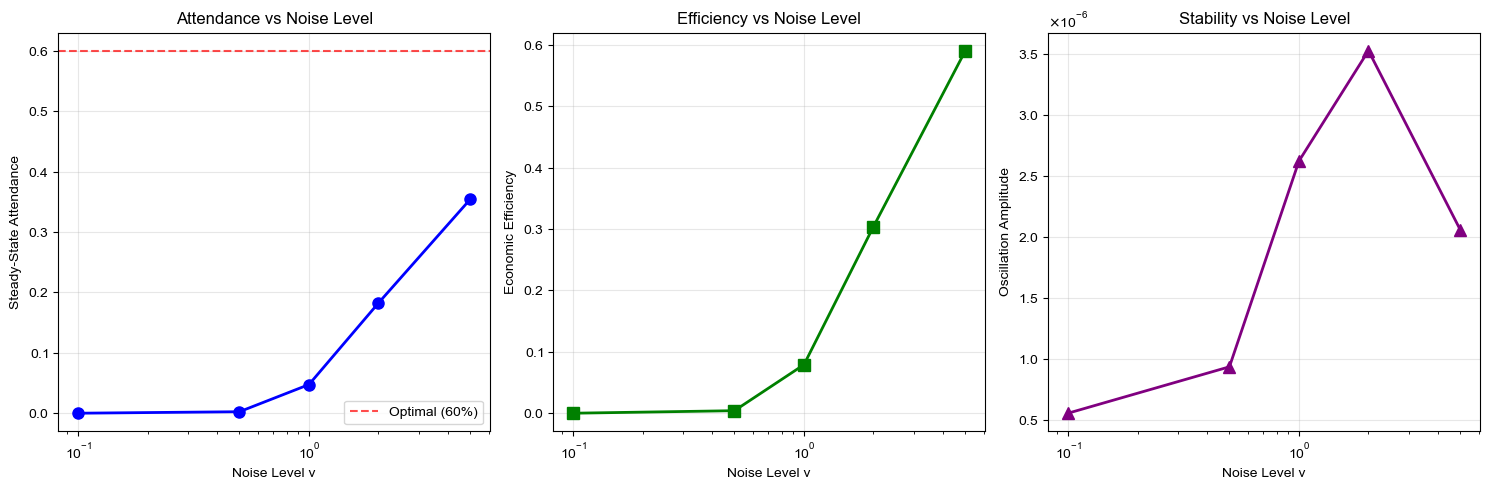


📊 Noise Sensitivity Results:
Noise Level | Attendance | Efficiency | Oscillation
--------------------------------------------------
       0.1 |      0.0% |      0.0% |      0.000
       0.5 |      0.2% |      0.4% |      0.000
       1.0 |      4.7% |      7.9% |      0.000
       2.0 |     18.2% |     30.4% |      0.000
       5.0 |     35.4% |     59.1% |      0.000


In [5]:
# Study the effect of noise parameter in discrete MFG
print("\n🔬 Parameter Sensitivity Analysis: Noise Level Effect")

noise_levels = [0.1, 0.5, 1.0, 2.0, 5.0]
noise_results = []

for noise in noise_levels:
    problem = DiscreteSantaFeBarMFG(
        T=15.0, m_threshold=0.6, payoff_good=3.0, payoff_bad=-1.0, noise_level=noise, initial_m=0.5
    )

    solution = problem.solve(nt=1500)
    analysis = problem.analyze_equilibrium(solution)

    noise_results.append(
        {
            "noise": noise,
            "attendance": analysis["steady_state_attendance"],
            "efficiency": analysis["efficiency"],
            "oscillation": analysis["oscillation_amplitude"],
        }
    )

# Plot noise sensitivity
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

noises = [r["noise"] for r in noise_results]
attendances = [r["attendance"] for r in noise_results]
efficiencies = [r["efficiency"] for r in noise_results]
oscillations = [r["oscillation"] for r in noise_results]

# Attendance vs Noise
ax1.semilogx(noises, attendances, "o-", markersize=8, linewidth=2, color="blue")
ax1.axhline(y=0.6, color="red", linestyle="--", alpha=0.7, label="Optimal (60%)")
ax1.set_xlabel("Noise Level ν")
ax1.set_ylabel("Steady-State Attendance")
ax1.set_title("Attendance vs Noise Level")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Efficiency vs Noise
ax2.semilogx(noises, efficiencies, "s-", markersize=8, linewidth=2, color="green")
ax2.set_xlabel("Noise Level ν")
ax2.set_ylabel("Economic Efficiency")
ax2.set_title("Efficiency vs Noise Level")
ax2.grid(True, alpha=0.3)

# Oscillation vs Noise
ax3.semilogx(noises, oscillations, "^-", markersize=8, linewidth=2, color="purple")
ax3.set_xlabel("Noise Level ν")
ax3.set_ylabel("Oscillation Amplitude")
ax3.set_title("Stability vs Noise Level")
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Noise Sensitivity Results:")
print("Noise Level | Attendance | Efficiency | Oscillation")
print("-" * 50)
for r in noise_results:
    print(f"{r['noise']:>10.1f} | {r['attendance']:>9.1%} | {r['efficiency']:>9.1%} | {r['oscillation']:>10.3f}")

## Theoretical Analysis and Conclusions

### Key Findings

1. **Mathematical Correctness**:
   - The **discrete MFG formulation** is mathematically exact for the Santa Fe Bar Problem
   - The **continuous MFG formulation** is an approximation through spatial embedding

2. **Behavioral Differences**:
   - **Discrete**: Pure coordination game with binary choices
   - **Continuous**: Spatial heterogeneity with tendency distributions

3. **Noise Parameter Effects**:
   - **Low noise** (ν → 0): Deterministic, extreme solutions
   - **High noise** (ν → ∞): Random behavior, approaches 50% attendance
   - **Moderate noise**: Balanced coordination with smooth transitions

4. **Solution Characteristics**:
   - **Discrete**: Fast convergence, clear equilibria
   - **Continuous**: Smooth dynamics, population distribution insights

### Mathematical Insights

**Discrete MFG Advantages**:
- Exact representation of binary choice
- Clear interpretation of transition probabilities
- Computationally efficient (ODEs vs PDEs)
- Direct connection to game theory

**Continuous MFG Advantages**:
- Models heterogeneous populations
- Rich spatial dynamics
- Connects to broader MFG theory
- Smooth approximation for analysis

### Practical Implications

- **For pure coordination problems**: Use discrete MFG
- **For heterogeneous agent models**: Use continuous MFG
- **For computational efficiency**: Discrete MFG preferred
- **For spatial phenomena**: Continuous MFG essential

### Future Directions

1. **Hybrid Models**: Combine discrete choices with continuous heterogeneity
2. **Learning Dynamics**: Adaptive behavior based on historical outcomes
3. **Network Effects**: Spatial or social network structures
4. **Multi-Agent Extensions**: Multiple bars, different agent types
5. **Stochastic Environments**: Time-varying capacities and preferences

---

**Conclusion**: Both formulations provide valuable insights, but the discrete MFG is mathematically correct for the original Santa Fe Bar Problem, while the continuous version offers a useful approximation with additional spatial structure.